In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.backend as K
import numpy as np
import pylab as plt

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tensorf

In [4]:


# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies





In [6]:
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
noisy_movies.shape

(1200, 15, 40, 40, 1)

In [ ]:
# Train the network

seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=10, validation_split=0.05)

In [ ]:
# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

In [3]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [4]:
import tensorflow as tf

In [5]:
labels = makeGaussian(32, fwhm = 3, center=(16, 16))
pred = makeGaussian(32, fwhm = 3, center=(10, 15))

In [6]:
labels.shape

(32, 32)

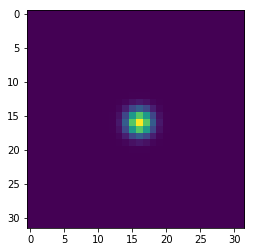

In [7]:
plt.imshow(labels)

In [8]:
tf.argmax(pred, axis=0)

<tf.Tensor: id=2, shape=(32,), dtype=int64, numpy=
array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])>

In [9]:
tf.argmax(pred, axis=1)[0], tf.argmax(pred, axis=0)[0]

(<tf.Tensor: id=10, shape=(), dtype=int64, numpy=10>,
 <tf.Tensor: id=17, shape=(), dtype=int64, numpy=15>)

In [25]:
labels = makeGaussian(32, fwhm = 3, center=(16, 16))
pred = makeGaussian(32, fwhm = 3, center=(16, 16))

K.sum(tf.losses.kullback_leibler_divergence(labels, pred))

<tf.Tensor: id=585, shape=(), dtype=float64, numpy=0.0>

tf.Tensor(22.199444, shape=(), dtype=float32)


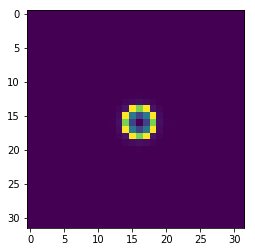

In [28]:
labels = makeGaussian(32, fwhm = 3, center=(16, 16))
pred = makeGaussian(32, fwhm = 3, center=(16, 16))
#pred = np.ones((32, 32))
#pred[pred < 0.01] = 0 
#labels = K.zeros((32,32))
labels = K.variable(labels > 0.2)
pred = K.variable(pred)
bce = K.binary_crossentropy(labels, pred)
print(K.sum(bce))
plt.imshow(bce)

In [31]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bootstrapped_crossentropy(y_true, y_pred, bootstrap_type='hard', alpha=0.95):
    target_tensor = y_true
    prediction_tensor = y_pred
    _epsilon = tf.convert_to_tensor(K.epsilon(), prediction_tensor.dtype.base_dtype)
    prediction_tensor = tf.clip_by_value(prediction_tensor, _epsilon, 1 - _epsilon)
    prediction_tensor = tf.math.log(prediction_tensor / (1 - prediction_tensor))

    if bootstrap_type == 'soft':
        bootstrap_target_tensor = alpha * target_tensor + (1.0 - alpha) * K.sigmoid(prediction_tensor)
    else:
        bootstrap_target_tensor = alpha * target_tensor + (1.0 - alpha) * K.cast(
            K.sigmoid(prediction_tensor) > 0.5, tf.float32)
    return K.mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=bootstrap_target_tensor, logits=prediction_tensor))

def dice_coef_loss_bce(y_true, y_pred, dice=0.5, bce=0.5, bootstrapping='hard', alpha=1.):
    return bootstrapped_crossentropy(y_true, y_pred, bootstrapping, alpha) * bce + dice_coef_loss(y_true, y_pred) * dice

In [36]:
labels = makeGaussian(32, fwhm = 3, center=(16, 16))
pred = makeGaussian(32, fwhm = 3, center=(16, 16))
#pred = np.ones((32, 32))
#pred[pred < 0.01] = 0 
#labels = K.zeros((32,32))
labels = K.variable(labels > 0.2)
pred = K.variable(pred > 0.2)
bce_dice = dice_coef_loss_bce(labels, pred, dice=0.8, bce=0.2, bootstrapping='soft', alpha=1)
print(K.sum(bce_dice))
# plt.imshow(bce_dice)

tf.Tensor(2.007877e-08, shape=(), dtype=float32)


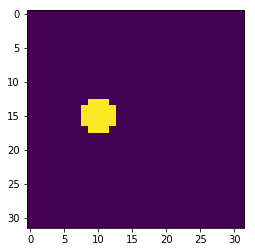

In [18]:
plt.imshow(pred > 0.2)